# SSW2023 Workshop 2 NIRSpec Solutions

## Author: Taylor Bell (Bay Area Environmental Research Institutite)

Run the [SWW2023_JWST_MIRI_NIRSpec_Setup](https://colab.research.google.com/drive/1fccr9FVwEsPhCzUhC4ah2FA9g0Q_AEMS?usp=sharing) notebook to download the data. The setup notebook needs to just be run **once** for both Hands-on I and II sessions.

## Google Colab Usage

*Please read (don't just hit run) the information given above each code cell as there are separate install cells for Colab*
&#128992;
*and running Python on your computer*
&#128309;.

**Confirm login account**
* Please make sure to be logged in with the Google account you want to use for the exercises before running the code cells below. You can check by clicking the circular account icon in the top right corner of the colab notebook.

**Working directory**
* Note: The data will be installed in a directory called "SSW2023" in your Google drive. This directory will be created if it does not exist.

**Running cells**
* Run cells individually by clicking on the triangle on each cell

**To Restart runtime**
*   Click on Runtime menu item
*   Select Restart runtime
*   Select Run code cells individually from the top

**To Recreate runtime**
*   Click on Runtime menu item
*   Select Disconnect and Delete runtime
*   Select Run code cells individually from the top

**To Exit:**
*   Close the browser window

# &#128992; Google Colab Setup and Installing Eureka!

**Important:** You will need to re-run these first two cells each time your runtime gets deleted.

&#128992; **This first cell will install Eureka!**

In [ ]:
# Change numpy version (required for theano)
!pip install numpy==1.21.6
# Install Eureka! (for now a dev branch, but in the future a stable branch)
!pip install eureka@git+https://github.com/kevin218/Eureka.git@dev/tjb

This next cell will connect your notebook to your Google Drive files.

&#128992; **Run this cell if you are running Google Colab.**

In [ ]:
# You will be prompted to Permit this notebook to access your Google Drive files - Click on "Connect to Google Drive"
# You will then be prompted to Choose an account - click on your preferred Google account
# You will then confirm that Google Drive for desktop wants to access your Google Account - scroll to click "Allow"
from google.colab import drive
drive.mount('/content/drive')

&#128992; **After the cell above outputs "Mounted at /content/drive", click the "Runtime"->"Restart runtime" in the top menu bar, and then you can proceed with the cells below**

# &#128309; Installing Eureka! on your computer

If you are running this on your computer instead of Google Colab, you should instead follow the installation instructions at https://eurekadocs.readthedocs.io/en/latest/installation.html.

---
# Setting up the notebook

The first step is to setup the notebook and environment.

We'll first import Eureka! along with some other useful packages.

*(You can safely ignore the warnings about jwst, starry, pymc3 - we didn't install them above to try and make the installation process a bit faster)*

In [ ]:
import eureka
import os
import numpy as np

Next, we will re-use the eventlabel from Workshop #1. The eventlabel is a short, meaningful label (without spaces) that describes the data you're currently working on. For simplicity, simply set `eventlabel = 'nirspec'`. This same event label should be used throughout all stages.

In [ ]:
eventlabel = 'nirspec'

# An introduction to Bayesian statistics

*The text discussing Bayesian statistics throughout this notebook is adapted from:*
<blockquote>Bell, Taylor James. "Characterizing Ultra-Hot Jupiters through Theoretical Modelling and Precise Observations." Doctoral Thesis, McGill University, 2021.</blockquote>

<br/>

**This introduction to Bayesian statistics can be skipped if you are already familiar, and you can resume at "Optimizing a fit to the white lightcurve".**

<br/>

This workshop will make heavy use of Bayesian statistics which is a fundamental aspect of most aspects of modern science and data analysis. According to Bayes' theorem, the probability, $P$, of a hypothesis, $H$, given a set of observations, $\mathbf{X}$, and a collection of prior knowledge, $I$, is given by
\begin{equation*}
    P(H|\mathbf{X},I) = \frac{P(\mathbf{X}|H,I) P(H|I)}{P(\mathbf{X}|I)},
\end{equation*}
where $|$ reads as "given" (that all terms to the right are assumed true), and the comma reads as "and". The power of Bayes' theorem is that it allows us to compute the *posterior probability*, $P(H|\mathbf{X},I)$, using the much more easily calculable *likelihood function*, $P(\mathbf{X}|H,I)$, which is the probability that we would have observed the data $\mathbf{X}$ if the hypothesis and prior knowledge were correct. The $P(H|I)$ term is the *prior probability* and summarizes how our prior knowledge affects our hypothesis before having measured the data $\mathbf{X}$. Finally, the $P(\mathbf{X}|I)$ term is the *evidence* or *marginal likelihood* and is often omitted when fitting a model to data as it is only a normalization term and does not depend on the hypothesis.

When fitting a set of observations, a hypothesis typically consists of a function describing the model which depends on a collection of parameters, $\theta$, and hyperparameters, $\alpha$. Bayes' theorem can then be re-written as
\begin{equation*}
    P(\theta|\mathbf{X},\alpha) \propto P(\mathbf{X}|\theta,\alpha) P(\theta|\alpha).
\end{equation*}
Fitting the observations usually starts by freezing the set of hyperparameters and then evaluating the posterior probability by comparing different model predictions to the observed data. Fitting the observations then requires determining the values of $\theta$ that maximize the posterior probability (called the Maximum A Posteriori estimate or MAP estimate), while determining the uncertainty on the model parameters involves determining the range of values of $\theta$ that provide an adequately good fit to the observations (called the confidence interval).

In principle, one could simultaneously estimate the optimal value of $\theta$ and its confidence interval from the posterior probability density function (PDF) by calculating the posterior probability for all values of $\theta$; this is called a grid search. While this technique may be feasible for discrete parameters or low dimensional problems, performing a grid search when the vector $\theta$ contains tens or thousands of continuous variables becomes immensely challenging and computationally inefficient. Instead, various algorithms can be used to compute the MAP estimate and the confidence interval, some of which we will make use of in this workshop.

# Optimizing a fit to the white lightcurve

In this section, we are going to find the MAP (often called "best-fit") model parameter values by fitting a "white" lightcurve using an optimization algorithm. As was discussed in Workshop #1, by "white" we mean wavelength-integrated, where the MIRI wavelengths used here span 5–10.5 micrometers.

Estimating the best-fit values of the parameters $\theta$ is often done using a gradient descent algorithm. This technique starts by picking either a random or partially informed initial estimate for the value of $\theta$ and then computing or estimating the gradient in the posterior PDF depending on whether or not the model is differentiable. In practice, most optimization methods are formulated as minimization routines (hence the name gradient *descent*), so it is more common to seek the minimum of the *negative* posterior probability. The algorithm will then take a small step in the direction in which the posterior probability most rapidly increases and then re-evaluate the gradient in the posterior PDF. This procedure is then repeated (typically with a gradually decreasing step size) until the algorithm locates a local maximum in the posterior PDF. The distinction of a local maximum rather than a global maximum is important as gradient descent routines do not explore the parameter space as thoroughly as a grid search, so it is possible for the algorithm to settle on a local maximum which compares poorly to the global maximum. This is typically overcome by running several gradient descent optimizations initialized at random locations in parameter space in the hopes that one of the optimizations will make its way to the global maximum (or at least alert you to the presence of many local maxima). As we'll see later, the posterior for the fits we'll be making in this workshop is pretty smooth, so we'll just run a single optimization run.

## Setting the Stage 5 "Eureka! Control File" (ECF)

**This determines what will happen during Stage 5**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S5_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5).

1. Set the `ncpu` parameter to `1`. Model optimization algorithms can typically only make use of one cpu thread, and since we're running this on Google Colab which only offers one thread there's no benefit to setting it higher.
2. Make sure `rescale_err` is set to `False` - we'll be using a different method of error inflation to ensure that we end up with a reduced chi-squared of unity.
3. Set `verbose` to `True` so you get lots of useful information printed out.
4. Set `fit_method` to `[lsq]` to use the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) algorithm to **minimize** the **negative** log-probability in order to find the best-fit values for each fitted parameter.
5. Set `run_myfuncs` to `[batman_tr, polynomial, ypos, ywidth]`. Each element in this list is a function that will be fitted to the data — we'll setup more aspects of each function below when we setup the "Eureka! Parameter File". The `batman_tr` function uses the [batman](http://lkreidberg.github.io/batman/docs/html/index.html) package to model a transit function which describes how the astrophysical flux decreases when the planet passes in front of its star blocks part of the star's light. The `polynomial` function allows us to fit for systematic trends in time (like a linear slope) as well as fitting for the overall baseline flux level; you must always use a `polynomial` model when fitting observations to at least model the baseline flux level. The `ypos` and `ywidth` functions model changes in the flux caused by changes in the position and PSF width of the spectrum on the detector in the spatial direction; we computed these during Stage 3 in Workshop #1. JWST is quite stable over time, so these functions just assume that the flux is linearly correlated with the spatial position and PSF width. Not all observations require that you use the `ypos` and `ywidth` functions, but as we saw in Workshop #1 there is a strong mirror-tilt event in these observations, as we are going to use `ypos` and `ywidth` to try to remove that sudden jump in flux.
6. Set `fit_par` to `./S5_fit_par_template.epf`. This tells Eureka! where you have specified the priors and initial guesses for the parameters the control the functions listed above.
7. Set `manual_clip` to `[[None,20]]`. This will remove the first 20 integrations which show a curved shape likely due to an effect called charge trapping.
8. Leave all parameters under the "Limb darkening controls" heading at their default values of `None` since we didn't produce model limb-darkening spectra in Workshop #1.
9. Set `lsq_method` to `Powell`. This controls which scipy.optimize.minimize optimization method will be used. In general, the Powell algorithm works very well.
10. Set `lsq_tol` to `1e-6`. This sets the error tolerance for the scipy.optimize.minimize optimization method, where a smaller value will result in a more precise estimate of the "best-fit" value, so long as the optimizer manages to converge. A value of `1e-6` will suffice for most datasets.
11. Leave `lsq_maxiter` at its default setting of `None`. This parameter can be used to let the optimzation routine run for longer if you get a message saying that the fit failed because the maximum number of function evaluations has been exceeded. This can sometimes happen when `lsq_tol` is set too small, when you're fitting a complex model with many parameters, or when there are strong degeneracies between two or more parameters.
12. For now, you can safely ignore all of the settings related to the dynesty, emcee, and nuts sampling algorithms - we'll come back to these later.
13. Set `isplots_S5` to `5` so that you see lots of useful plots that can help you debug your fits.
14. Set `nbin_plot` to `None` since we're not fitting that many integrations and we don't really need to temporally bin the data when plotting to be able to see our astrophysical signal.
15. Set `hide_plots` to `False` so that all your figures appear within the notebook (you can set this to `True` if you're running the code from the terminal and want to avoid an excessive number of pop-ups appearing).
16. &#128992; Set `topdir` to the folder containing your input "white" Stage 4 folder. This should start with /content/drive/MyDrive/ (this is where your Google Drive files get mounted) and then specify the folder structure you setup. For example, if your Stage4_white files on Google Drive are in SSW2023→WASP39b_NIRSpec→Stage4_white, then set `topdir` to `/content/drive/MyDrive/SSW2023/WASP39b_NIRSpec`. This `topdir` setting will use our provided Stage 4 output files, but if you want to try using your own results from Workshop #1, you can instead set `topdir` to `/content/drive/MyDrive/SSW2023/NIRSpec`. &#128309; If you are using the Jupyter notebook, set `topdir` to the full parent directory of the input "white" Stage4 directory, either choosing to use our provided Stage4_white files or your own from Workshop #1.
17. Since we're fitting white lightcurves, we'll adjust the `inputdir` to `Stage4_white` and the `outputdir` to `Stage5_white`. Depending on the `topdir` setting you used, this will either use our provided Stage 4 output files or your own results from Workshop #1. If you're using your own results from Workshop #1, setting `intputdir` to `Stage4_white` will use your most recent Stage4_white result, but you can also choose a specific run using the syntax `Stage4_white/S4_YYYY-MM-DD_nirspec_runN` where YYYY is the year (e.g., `2023`), MM is the month (e.g., `07`), DD is the day (e.g., `24`), and N is the particular run number that you want to use (e.g., `1`).

In [ ]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

ncpu             1        # The number of CPU threads to use when running emcee, dynesty, or pymc3 in parallel

allapers         False    # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err      False    # Rescale uncertainties to have reduced chi-squared of unity
verbose          True     # If True, more details will be printed about steps

# NORMAL FITTING
fit_method       [lsq]    # Which fitting methods do you want to use? This can be a list if you want to run multiple fitters (e.g. an optimizer and then a sampler that will start from the optimizer's final position).
run_myfuncs      [batman_tr, polynomial, ypos, ywidth]    # What functions do you want to fit?
fit_par          ./S5_fit_par_template.epf

# Manual clipping in time
manual_clip      [[None,20]]    # A list of lists specifying the start and end integration numbers for manual removal.

# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None    # Use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None    # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None    # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# LSQ Settings
lsq_method       Powell
lsq_tol          1e-6
lsq_maxiter      None

# Plotting controls
interp           False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5       5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot        None    # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5       False   # Boolean, set True to only use the first spectral channel
testing_model    False   # Boolean, set True to only inject a model source of systematics
hide_plots       False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir           /content/drive/MyDrive/SSW2023/NIRSpec

# Directories relative to project dir
inputdir         Stage4_white
outputdir        Stage5_white
"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Setting the Stage 5 "Eureka! Parameter File" (EPF)

**This determines the priors and starting guesses for your fitted models**

Here is where we dive further into specifying details about the models that we want to fit to our data. We'll discuss the ones relevant to this fit below, but more details can be found on the [Eureka documentation webpage](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-5-fit-parameters).

Each row has 6 columns:
> `Name Value Free? PriorPar1 PriorPar2 PriorType`

`Name` specifies the name of a fitted variable. These have to be from a very specific list of options so that Eureka! knows what the variable is supposed to mean. For example `rp` is the planet-to-star radius ratio (so `rp` squared would be equal to the transit depth) and `fp` is the eclipse depth.

`Value` specifies the starting guess for the variable. This column is used for all optimization or sampling algorithms except dynesty which does not take a starting guess. In general, starting guesses do not need to be exceptionally good, and as long as they're in the vague ballpark then the fitting or sampling algorithm should work fine. For fixed parameters (see the description of `Free?` below), this column sets the value of the parameter.

`Free?` specifies whether the parameter should be freely fitted for each wavelength (`'free'`), should be set to a fixed value and not changed throughout the fit (`'fixed'`), is an auxilliary variable that also should not be fit (`'independent'`). Other more advanced options also exist, but we won't cover them here. For fixed and independent variables, the remaining three columns are not used.

**The rightmost column**, `PriorType`, determines what type of prior function you will use to constrain your fitted parameters. The three options are Normal (`N`; also known as a Gaussian prior), Uniform (`U`), and Log-Uniform (`LU`). Some sampling algorithms work faster or more efficiently with Normal priors, but sometimes you must use Uniform priors to avoid unphysical parameter settings. Normal priors are typically best for orbital parameters for which there are published best-fit values and uncertainties.

The meanings of the `PriorPar1` and `PriorPar2` columns are dependent on the setting of the `PriorType` column (which is the last column). If `PriorType` is N, then `PriorPar1` is the mean of the Gaussian prior and `PriorPar2` is the standard deviation. If `PriorType` is U, then `PriorPar1` is the lower limit of the parameter and `PriorPar2` is the upper limit of the parameter. If `PriorType` is LU, then `PriorPar1` is the lower limit of the log of the parameter, and `PriorPar2` is the upper limit of the log of the parameter.


<br/>

---

<br/>


For your fit, you will need the following variables: `rp`, `per`, `t0`, `time_offset`, `inc`, `a`, `ecc`, `w`, `c0`, `c1`, `ypos`, `ywidth`, `scatter_mult`.

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S5_fit_par_template.epf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

- For `per` (planetary orbital period), `t0` (time of conjunction; also called linear ephemeris or transit midpoint), `inc` (planetary orbital inclination), `a` (planetary orbital semi-major axis), `ecc` (planetary orbital eccentricity), and `w` (planetary orbital argument of periastron) we will make use of previously published research. Navigate to the [NASA Exoplanet Archive's page](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39b) about our target WASP-39b and click on "WASP-39 b Planetary Parameters". We will use the values published by Maciejewski et al. 2016 as priors. Where there are two values for the uncertainty, just use the larger of the two. Also, while the published `t0` is in units of BJD_TDB, JWST timestamps are in units of B**M**JD_TDB, where the M means "modified" and BMJD_TDB=BJD_TDB-2400000.5; this removes the first two digits that won't change in our lifetime and changes the time so that a new BMJD_TDB day starts at midnight (while new BJD_TDB days inconventiently start at noon). So we will need to subtract that 2400000.5 from the published `t0` value when entering it into your EPF. And since the planet is consistent with a zero-eccentricity orbit, let's set `ecc` to be fixed to 0 and arbitrarily set `w` to be fixed to 90 (the value of `w` doesn't matter if the eccentricity is zero). In summary, you should have:
> `per 4.0552765 'free' 4.0552765 0.0000035 N`<br/>
> `t0 55342.46982 'free' 55342.46982 0.00051 N`<br/>
> `inc 87.75 'free' 87.75 0.27 N`<br/>
> `a 11.37 'free' 11.37 0.24 N`<br/>
> `ecc 0 'fixed'`<br/>
> `w 90 'fixed'`<br/>

- For rp (planet-to-star radius ratio), we'll also use the published value from Maciejewski et al. 2016 as a Normal prior. However, this is the main value that we are hoping to measure with our observations and we want to be able to see how the radius changes with wavelength. As a result, we will greatly increase the uncertainty on the radius to `0.01` in order to minimally bias our observations. In summary, set:
> `rp 0.1457 'free' 0.1457 0.01 N`

- Leave time_offset at it's default settings of:
> `time_offset 0 'independent'`.

- No star is completely uniform in brightness across its surface, and one of the main sources of non-uniformity is called limb-darkening where the ceter of the star appears brighter than the edges of the star. A convenient and efficient way of modelling this limb-darkening was published in [Kipping (2013)](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.2152K/abstract). With this limb-darkening law, there are two parameters to be fitted and each can theoretically take on any value between 0 and 1. To let Eureka! fit these limb-darkening parameters, set:
> `limb_dark 'kipping2013' 'independent'`<br/>
> `u1 0.5 'free' 0 1 U`<br/>
> `u2 0.5 'free' 0 1 U`

- Our systematics models are controlled by
  - `c0` (the baseline flux level) and `c1` (which fits for a linear slope as a function of time). These two parameters control the `polynomial` function we specified in the ECF settings above. To make things easier, Eureka! normalizes the lightcurves by the median flux, so the value of `c0` should be approximately 1, but since our observations have such a large transit it will be a bit above 1. The value of `c1` is in the units of change in `c0` per day, and is typically very small (the absolute value of `c1` is typically at or below 0.001. Reasonable, minimally informative priors could then be:
  > `c0 1 'free' 1 0.01 N`<br/>
  > `c1 0 'free' 0 0.01 N`
  - `ypos` which assumes the observed flux varies linearly with the position on the detector. This can happen because of flux lost outside of our extraction aperture or between gaps between pixels. Values for `ypos` are typically well below 1, so a reasonable, minimally informative prior could then be:
  > `ypos 0 'free' 0 0.1 N`
  - and `ywidth` which assumes the observed flux varies linearly with the PSF width of the spectrum. This can happen because of flux lost outside of our extraction aperture or between gaps between pixels. Values for `ywidth` can sometimes reach as high as ~1, so a reasonable, minimally informative prior could then be:
  > `ywidth 0 'free' 0 10 N`

- We also need to setup `scatter_mult`. Eureka! estimates the expected level of noise from photon-limited statistics, but data is imperfect and we rarely ever reach the photon-limited noise level (because of background noise, read noise, and other systematic noise sources). If you fit data with underestimated error bars, then the resulting confidence intervals can be artificially small, so we want to inflate the error bars on our observations as is justified by the data. The simplest way to do this with Eureka! is the `scatter_mult` parameter which multiplies the error bars by a constant factor. A fitted value of 2 for `scatter_mult` would mean that the observed scatter in the data is twice as high as it would be in the photon-limited noise regime. NIRSpec data is typically pretty well behaved though, and a reasonable, minimally informative prior could be:
> `scatter_mult 1.4 'free' 1.4 2 N`

**Finally, delete or comment-out (with `#`) all other parameters not mentioned above.**

In [ ]:
s5_epf_contents = f"""
# Name      Value           Free?			    PriorPar1      PriorPar2  PriorType
#-------------------------------------------------------------------------------------------------------
# Astrophysical priors from Maciejewski et al. 2016
# ------------------
# ** Transit parameters **
# ------------------
rp          0.1457        'free'        0.1457          0.01       N
# ------------------
# Orbital parameters
# ------------------
per         4.0552765     'free'        4.0552765       0.0000035  N
t0          55342.46982   'free'        55342.46982     0.00051    N
time_offset 0             'fixed'
inc         87.75         'free'        87.75           0.27       N
a           11.37         'free'        11.37           0.24       N
ecc         0.            'fixed'
w           90            'fixed'
# -------------------------
# Limb darkening parameters
# Choose limb_dark from ['uniform', 'linear', 'quadratic', 'kipping2013', 'square-root', 'logarithmic', 'exponential', '4-parameter']
# -------------------------
limb_dark   'kipping2013' 'independent'
u1          0.5           'free'        0               1          U
u2          0.5           'free'        0               1          U
# --------------------
# Systematic variables
# --------------------
c0          1.0           'free'        1.0             0.01       N
c1          0             'free'        0               0.01       N
# Centroid decorrelation parameters
ypos        0             'free'        0.              0.1        N
ywidth      0             'free'        0.              10         N
# -----------
# White noise
# -----------
scatter_mult 1.4          'free'        1.4             2          N
"""

with open('S5_fit_par_template.epf', 'w') as f:
    f.write(s5_epf_contents)

## Running Eureka!'s Stage 5

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following fit should take &lt;1 minute to complete on Google Colab.

In [ ]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Sampling white lightcurve posterior

Estimating the confidence interval of our parameters $\theta$ could be done by extrapolating the posterior PDF from the MAP value using the first and second order gradient and then determining the extent to which each component of $\theta$ can be changed while still providing an adequately good fit to the observations. However, this technique can give inaccurate estimates especially in the presence of correlations between different parameters. Instead, a sampling algorithm like the Markov Chain Monte-Carlo (MCMC) method is typically used to estimate parameter uncertainties. Monte-Carlo (MC) methods in general involve randomly sampling values of $\theta$, while MCMCs are a specific variant where samples are randomly drawn based on the knowledge of the posterior probability from the previously drawn value; the draws of MCMC are typically called steps taken by a walker, and a collection of many walker steps are called a chain.

One increasingly popular sampling algorithm is called [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) which does not necessarily use a MCMC method. Nested sampling can be difficult to explain intuitively, but one of the nice advantages to nested sampling is that it can be used for model comparison. More relevant to our purposes here, the [dynesty](https://dynesty.readthedocs.io/en/stable/) dynamic nested sampling algorithm is able to quickly sample our posterior and has a convenient stopping condition which ensures the sampler has converged so that we get reliable uncertainties.

## Adjusting the Stage 5 "Eureka! Control File" (ECF)

Thankfully we can reuse the vast majority of our ECF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the ECF that you filled out above. Then:

1. Change `fit_method` to be `[dynesty]` to instead use the dynesty sampler.
2. Add the following dynesty-related settings
  1. Set `run_nlive` to `121`. This sets the number of "live" points that dynesty will use (for more details see [here](https://dynesty.readthedocs.io/en/stable/faq.html#live-point-questions)). For reliable results, this must be greater than `ndim * (ndim + 1) // 2`, where `ndim` is the number of fitted parameters and `//` indicates integer division. In general, the larger this number the more robust your results will be and the longer they will take to run. A value of `121` is a fairly reasonable balance of speed and quality.
  2. Set `run_bound` to `'multi'`. This sets the type of bounds used by dynesty to "multiple ellipsoid decomposition". For more information, see [here](https://dynesty.readthedocs.io/en/stable/faq.html#bounding-questions). A value of `'multi'` should work for most problems.
  3. Set `run_sample` to `'auto'`. This lets dynesty choose the optimal sampling method based on the number of fitted parameters, and `auto` is a safe bet for most problems. For more information, see [here](https://dynesty.readthedocs.io/en/stable/faq.html#sampling-questions).
  4. Finally, set `run_tol` to `0.1`. This determines the stopping condition of the sampler. Smaller values will result in more precise posteriors at the cost of increased runtime, while larger values can result in poorly converged garbage. In general, a value of `0.1` should work for most problems.

In [ ]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

ncpu             1        # The number of CPU threads to use when running emcee, dynesty, or pymc3 in parallel

allapers         False    # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err      False    # Rescale uncertainties to have reduced chi-squared of unity
verbose          True     # If True, more details will be printed about steps

# NORMAL FITTING
fit_method       [dynesty]    # Which fitting methods do you want to use? This can be a list if you want to run multiple fitters (e.g. an optimizer and then a sampler that will start from the optimizer's final position).
run_myfuncs      [batman_tr, polynomial, ypos, ywidth]    # What functions do you want to fit?
fit_par          ./S5_fit_par_template.epf

# Manual clipping in time
manual_clip      [[None,20]]    # A list of lists specifying the start and end integration numbers for manual removal.

# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None    # Use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None    # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None    # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# LSQ Settings
lsq_method       Powell
lsq_tol          1e-6
lsq_maxiter      None

# Dynesty Settings
run_nlive       121    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

# Plotting controls
interp           False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5       5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot        None    # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5       False   # Boolean, set True to only use the first spectral channel
testing_model    False   # Boolean, set True to only inject a model source of systematics
hide_plots       False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir           /content/drive/MyDrive/SSW2023/NIRSpec

# Directories relative to project dir
inputdir         Stage4_white
outputdir        Stage5_white
"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Running Eureka!'s Stage 5

Because we want to use the exact same model and priors as our previous optimization run, there is no need to update our EPF and the code will just re-use the one we made above.

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following fit should take ~7 minutes to complete on Google Colab. While waiting for the fits to complete, you could begin setting up the next section.

In [ ]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Optimizing fits to spectroscopic lightcurves

Now that we know how to find best-fit values and uncertainties from a single "white" lightcurve, it is easy to extrapolate those skills to perform fits to "spectroscopic" lightcurves to evaluate how parameters like the eclipse depth vary as a function of wavelength (which can tell us about molecules in the planets' atmospheres).

## Adjusting the Stage 5 "Eureka! Control File" (ECF)

Thankfully we can reuse the vast majority of our ECF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the ECF that you filled out above. Then:

1. Change `fit_method` back to `[lsq]` to go back to using the optimization algorithm. Running dynesty on each channel will take too long to be completed during this workshop but could be an interesting exercise on your own.
2. Since we're now fitting spectroscopic lightcurves, we'll adjust the `inputdir` to `Stage4` and the `outputdir` to `Stage5`. Depending on the `topdir` setting you used, this will either use our provided Stage 4 output files or your own results from Workshop #1. If you're using your own results from Workshop #1, setting `intputdir` to `Stage4` will use your most recent Stage4 result, but you can also choose a specific run using the syntax `Stage4/S4_YYYY-MM-DD_nirspec_runN` where YYYY is the year (e.g., `2023`), MM is the month (e.g., `07`), DD is the day (e.g., `24`), and N is the particular run number that you want to use (e.g., `1`).

And that's it for adjustments to the ECF!

In [ ]:
s5_ecf_contents = f"""
# Eureka! Control File for Stage 5: Lightcurve Fitting

ncpu             1        # The number of CPU threads to use when running emcee, dynesty, or pymc3 in parallel

allapers         False    # Run S5 on all of the apertures considered in S4? Otherwise will use newest output in the inputdir
rescale_err      False    # Rescale uncertainties to have reduced chi-squared of unity
verbose          True     # If True, more details will be printed about steps

# NORMAL FITTING
fit_method       [lsq]    # Which fitting methods do you want to use? This can be a list if you want to run multiple fitters (e.g. an optimizer and then a sampler that will start from the optimizer's final position).
run_myfuncs      [batman_tr, polynomial, ypos, ywidth]    # What functions do you want to fit?
fit_par          ./S5_fit_par_template.epf

# Manual clipping in time
manual_clip      [[None,20]]    # A list of lists specifying the start and end integration numbers for manual removal.

# Limb darkening controls
# IMPORTANT: limb-darkening coefficients are not automatically fixed then, change to 'fixed' in .epf file whether they should be fixed or fitted!
use_generate_ld  None    # Use the generated limb-darkening coefficients from Stage 4? Options: exotic-ld, None. For exotic-ld, the limb-darkening laws available are linear, quadratic, 3-parameter and 4-parameter non-linear.
ld_file          None    # Fully qualified path to the location of a limb darkening file that you want to use
ld_file_white    None    # Fully qualified path to the location of a limb darkening file that you want to use for the white-light light curve (required if ld_file is not None and any EPF parameters are set to white_free or white_fixed).

# LSQ Settings
lsq_method       Powell
lsq_tol          1e-6
lsq_maxiter      None

# Dynesty Settings
run_nlive       121    # Must be > ndim * (ndim + 1) // 2
run_bound       'multi'
run_sample      'auto'
run_tol         0.1

# Plotting controls
interp           False   # Should astrophysical model be interpolated (useful for uneven sampling like that from HST)

# Diagnostics
isplots_S5       5       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nbin_plot        None    # The number of bins that should be used for figures 5104 and 5304. Defaults to 100.
testing_S5       False   # Boolean, set True to only use the first spectral channel
testing_model    False   # Boolean, set True to only inject a model source of systematics
hide_plots       False   # If True, plots will automatically be closed rather than popping up

# Project directory
topdir           /content/drive/MyDrive/SSW2023/NIRSpec

# Directories relative to project dir
inputdir         Stage4
outputdir        Stage5
"""

with open(f'S5_{eventlabel}.ecf', 'w') as f:
    f.write(s5_ecf_contents)

## Adjusting the Stage 5 "Eureka! Parameter File" (EPF)

Thankfully we can reuse the vast majority of our EPF settings above with only a few minor tweaks.

To begin, please first copy below the contents of the EPF that you filled out above. Then you just need to set any parameters that cannot vary with wavelength to be `'fixed'`. The relevant parameters that cannot vary with wavelength are the orbital parameters which are `per`, `t0`, `a`, and `inc`.

One option is to fix these parameters to the best-fit values obtained from your optimization run near the top of the notebook. Alternatively, you could also fix them to the published values from Maciejewski et al. 2016. If you go with the former, copy-paste your best-fit values for `per`, `t0`, `a`, and `inc` into the `Value` column and set the `Free?` column to `'fixed'`. If you go with the latter option, you just need to set the `Free?` column to `'fixed'`.

In [ ]:
s5_epf_contents = f"""
# Name      Value           Free?			    PriorPar1      PriorPar2  PriorType
#-------------------------------------------------------------------------------------------------------
# Astrophysical priors from Maciejewski et al. 2016
# ------------------
# ** Transit parameters **
# ------------------
rp          0.1457        'free'        0.1457          0.01       N
# ------------------
# Orbital parameters
# ------------------
per         4.05528013746 'fixed'
t0          55342.4698591 'fixed'
time_offset 0             'fixed'
inc         87.7277497625 'fixed'
a           11.3692910340 'fixed'
ecc         0.            'fixed'
w           90            'fixed'
# -------------------------
# Limb darkening parameters
# Choose limb_dark from ['uniform', 'linear', 'quadratic', 'kipping2013', 'square-root', 'logarithmic', 'exponential', '4-parameter']
# -------------------------
limb_dark   'kipping2013' 'independent'
u1          0.5           'free'        0               1          U
u2          0.5           'free'        0               1          U
# --------------------
# Systematic variables
# --------------------
c0          1.0           'free'        1.0             0.01       N
c1          0             'free'        0               0.01       N
# Centroid decorrelation parameters
ypos        0             'free'        0.              0.1        N
ywidth      0             'free'        0.              10         N
# -----------
# White noise
# -----------
scatter_mult 1.4          'free'        1.4             2          N
"""

with open('S5_fit_par_template.epf', 'w') as f:
    f.write(s5_epf_contents)

## Running Eureka!'s Stage 5

The following cell will run Eureka!'s Stage 5 using the settings you defined above. Note that your ECF and EPF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The code will loop through each wavelength channel, printing information about the fit and showing plots as it goes.

The following fits should take a total of ~7 minutes to complete on Google Colab. While waiting for the fits to complete, you could begin setting up the next section.

In [ ]:
s5_meta = eureka.S5_lightcurve_fitting.s5_fit.fitlc(eventlabel)

# Gathering together spectroscopic fits

Now that we've completed fits to the 50 spectroscopic channels, we want an easy way of seeing how different parameters vary with wavelength. Of particular interest is the transit depth (`rp^2`) — the variations in transit depth as a function of wavelength is called an transmission spectrum and can be used to determine the presence and abundance of molecules in the atmosphere of an exoplanet. Because we only used the `lsq` optimization algorithm above, our transmission spectrum will not have error bars. If you want to know what the spectrum looks like with error bars, you'll have to re-run your spectroscopic fits above using a sampler like dynesty.

## Setting the Stage 6 "Eureka! Control File" (ECF)

**This determines what will happen during Eureka!'s Stage 6**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S6_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-6).

1. Set `y_params` to `['rp^2']`. Eureka! is able to plot any of the `'free'` parameters from your fits as a function of wavelength as well as a very limited number of convenient transformations (e.g., `rp^2` to get the transit depth), but the only one we're really interested in here is `rp^2`.
2. Set `y_scalars` to `[100]` so that units of % are used for a plot that is easier to read.
3. We will also set some parameters to let Eureka! estimate the [atmospheric scale height](https://en.wikipedia.org/wiki/Scale_height) of WASP-39b; this will help us understand the strength of different molecular features in our transmission spectrum. We will again navigate to the [NASA Exoplanet Archive's page](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39b) about our target WASP-39b. We will again use the published values from Maciejewski et al. 2016 to keep everything self-consistent. First, click on "WASP-39 Stellar Parameters" and note the stellar radius (ignoring the uncertainty) in units of Solar radii in your ECF below beside `star_Rad`. Then, click on "WASP-39 b Planetary Parameters" and note the planetary mass in Jupiter masses beside `planet_Mass`. Since Maciejewski et al. 2016 didn't publish an equilibrium temperature, grab the value from Sing et al. 2016 and put the equilibtrium temperature in units of Kelvin beside `planet_Teq`. We will leave `planet_Rad` at it's default setting of `None` to use our mean fitted radius as the radius of the planet. We will also leave `planet_mu` at it's default setting of `2.3` AMU which is the approximate mean-molecular weight of most gas giant planets. And finally, we will leave `planet_R0` at it's default setting of `None` to use the mean featted radius as the reference height for the scale height axis. In summary, you should set:
> `star_Rad 0.918`
> `planet_Teq 1120`
> `planet_Mass 0.283`
> `planet_Rad None`
> `planet_mu 2.3`
> `planet_R0 None`

4. Set `topdir` to the same value as you used in your Stage 5 spectroscopic fits.

That's all we need to change for our purposes here, and all the other parameters can be left at their default settings.

In [ ]:
s6_ecf_contents = f"""
# Eureka! Control File for Stage 6: Spectra Plotting

allapers        False  # Run S6 on all of the apertures considered in S5? Otherwise will use newest output in the inputdir

# Plotting parameters
y_params        ['rp^2']  # The parameter name as entered in your EPF file in Stage 5
y_labels        None   # The formatted string you want on the y-label
y_label_units   None   # The formatted string for the units you want on the y-label - e.g., (ppm), (seconds), '(days$^{-1})$', etc.. Set to None to automatically add any implied units from y_scalars (e.g. ppm), or set to '' to force no units.
y_scalars       [100]   # Can be used to convert to percent (100), ppm (1e6), etc.
x_unit          um     # Options include any measurement of light included in astropy.units.spectral (e.g. um, nm, Hz, etc.)

# This section is relevant if isplots_S6>=3
# Scale height parameters (if you want a second copy of the plot with a second y-axis with units of scale height)
star_Rad        0.918  # The radius of the star in units of solar radii
planet_Teq      1120   # The equilibrium temperature of the planet in units of Kelvin
planet_Mass     0.283  # The planet's mass in units of Jupiter masses (used to calculate surface gravity)
planet_Rad      None   # The planet's radius in units of Jupiter radii (used to calculate surface gravity); Set to None to use the average fitted radius
planet_mu       2.3    # The mean molecular mass of the atmosphere (in atomic mass units)
planet_R0       None   # The reference radius (in Jupiter radii) for the scale height measurement; Set to None to use the mean fitted radius

# Diagnostics
isplots_S6      5      # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
hide_plots      False  # If True, plots will automatically be closed rather than popping up

# Project directory
topdir          /content/drive/MyDrive/SSW2023/NIRSpec

# Model to plot underneath the fitted data points
model_spectrum  None   # Path to the model spectrum relative to topdir. Set to None if no model should be plotted.
model_x_unit    um     # Options include any measurement of light included in astropy.units.spectral (e.g. um, nm, Hz, etc.)
model_y_param   rp^2   # Follow the same format as y_params. If desired, can be rp if y_params is rp^2, or vice-versa.
model_y_scalar  1      # Indicate whether model y-values have already been scaled (e.g. write 1e6 if model_spectrum is in ppm)
model_zorder    0      # The zorder of the model on the plot (0 for beneath the data, 1 for above the data)
model_delimiter None   # Delimiter between columns. Typical options: None (for space), ',' for comma

# Directories relative to project dir
inputdir        Stage5
outputdir       Stage6
"""

with open(f'S6_{eventlabel}.ecf', 'w') as f:
    f.write(s6_ecf_contents)

## Running Eureka!'s Stage 6

The following cell will run Eureka!'s Stage 6 using the settings you defined above. Note that your ECF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

The following stage should take &#8810;1 minute to complete on Google Colab.

In [ ]:
s6_meta = eureka.S6_planet_spectra.s6_spectra.plot_spectra(eventlabel)

Two plots should have been generated. The second plot is a clone of the first with the addition of a second y-axis on the right showing the amplitude of features in atmospheric scale heights to help you interpret the size of features.

As you can see from your transmission spectrum, the mean transit depth is around 2.15%. There is a clearly visible large bump at ~4.35 microns which is caused by CO<sub>2</sub> absorption, and to the left of that bump there is also a shallower bump centered around ~4.05 microns which is caused by SO<sub>2</sub>. The abnormally low point around 4.6 microns is likely spurious and caused by imperfect processing in Stages 1--4 or imperfect fitting in Stage 5. In the next workshops, we'll learn how we can use forward models and retrievals to interpret transmission and/or emission spectra.

# Double-checking work against ERS results

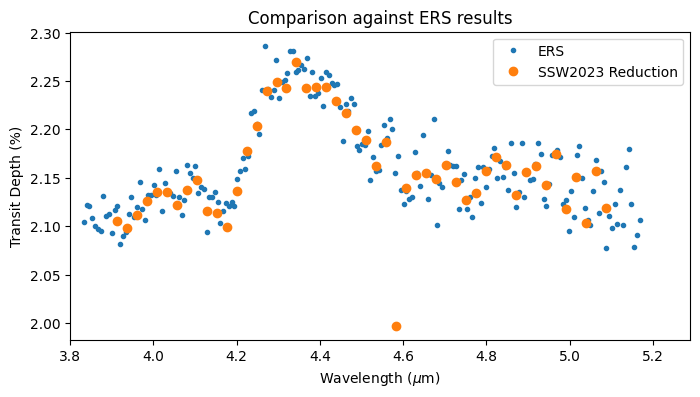

The ERS team didn't see the spuriously bad wavelength bin, but overall there is great agreement between the reductions. The ERS results is the "transit-spectrum-W39b-G395H-10pix_weighted-average.nc" file hosted on [zenodo](https://zenodo.org/record/7185300).